# NVIDIA Prize Eligibility
1. In this project we implement an optimal (in depth) exact amplitude encoding scheme known as QPIXL and augment its capabilities by finding that it can have $N$ different arrays simulatneously encoded for arrays that are of size $2^N$. Furthermore, we implement parameterized versions of these circuits in CUDA quantum, pennylane and qiskit variants, so that they can be used for QML tasks with the Parallel QPIXL as an ansatz for state preparation. 
2. The problem of amplitude embedding is of utmost importance for quantum processing of classical data. Having an efficient way to 'import' data into a quantum state, where it may be combined with other quantum enhanced features and then run through a QML algorithm or other time evolution would make for amazing research questions that go beyond full quantum or full classical ML paradigms, and perhaps form a combined quantum+classical data paradigm for QML (be it fully quantum or hybrid). Furthermore, it may be possible to encode more complex initial states for other algorithms, since the circuit structure is simple enough to preprocess classically, and the form of the state is exactly known, so that a quantum algorithm can continue on, via time evolution or other means, to compute observables of interest off of much better initial states. Of course, this is all exact and in the realm of fault tolerant quantum computing. Nonetheless, there are growing hints (such as those of QuEra), that fault tolerant computing may exist sooner than expected. 
3. We use CUDA quantum and NVIDIA GPUs in the backend to process the very wide and deep circuits generated by this algorithm, and have written implementations of it for both standard data encoding and also as an 'ansatz' with variational parameters by assigning the angles via the ```qc,vars = kernel(list)```, which can be found in the ```QPIXL_CuQuantum``` folder. Although the example notebook was run with the qiskit implementation, the statevector simulator was made to use the CuQuantum simulator. For the machine learning task, we modified the hybrid quantum neural network example on the MNIST dataset by embedding the data into the Parallel QPIXL algorithm and classify it with a tree tensor network classifier circuit appended to the end. 
4. The performance results and scientific and numerical analysis are described in detail below, in such a way that the embedding is made clear, building up to the QML results. Suffice it to say that with the large states that are being dealt with, there was no way to simulate such circuits in a reasonable amount of time without NVIDIA GPUs. Below there is a figure showing the imporvement of parallelizing the data storage procedure to store an array of length $2^n$, where $n$ is the number of address qubits. Details of both QPIXL and this parallelization are dexribed in the rest of the PDF. 

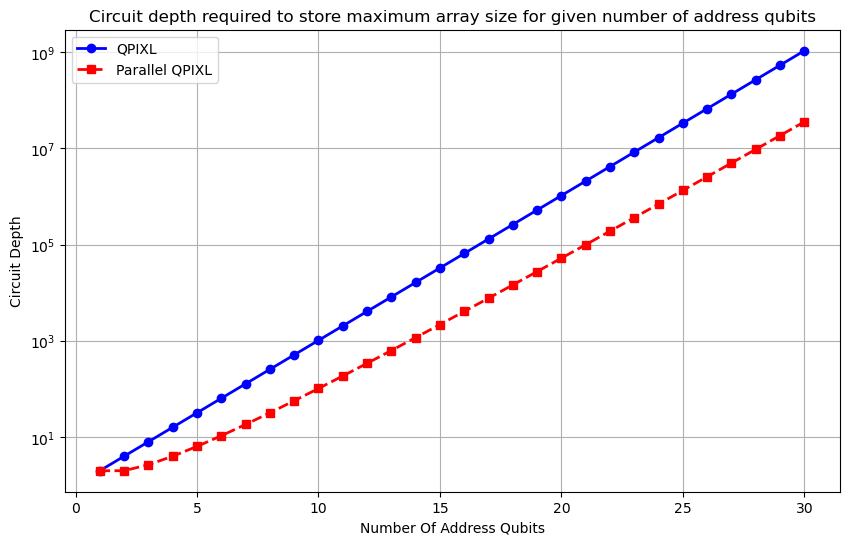

In [15]:
import matplotlib.pyplot as plt

x = list(range(1,31))
y1 = [2**i for i in x]
y2 = [i/j for i,j in zip(y1,x)]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first line
plt.plot(x, y1, label='QPIXL', color='b', marker='o', linestyle='-', linewidth=2)

# Plot the second line
plt.plot(x, y2, label='Parallel QPIXL', color='r', marker='s', linestyle='--', linewidth=2)
plt.yscale('log')
# Customize the plot
plt.title('Circuit depth required to store maximum array size for given number of address qubits')
plt.xlabel('Number Of Address Qubits')
plt.ylabel('Circuit Depth')
plt.grid(True)
plt.legend()
plt.show()

If we look at average runtime, we see, as expected, that the GPU outperforms CPU implementations of the simulators, but comparing CUDA quantum and the Qiskit GPU statevector simulator doesn't give a large difference at these qubit counts. The trend is that CUDA quantum somewhat outperforms Qiskit in this regard. All computations were run on the same machine with minimal other running programs. 

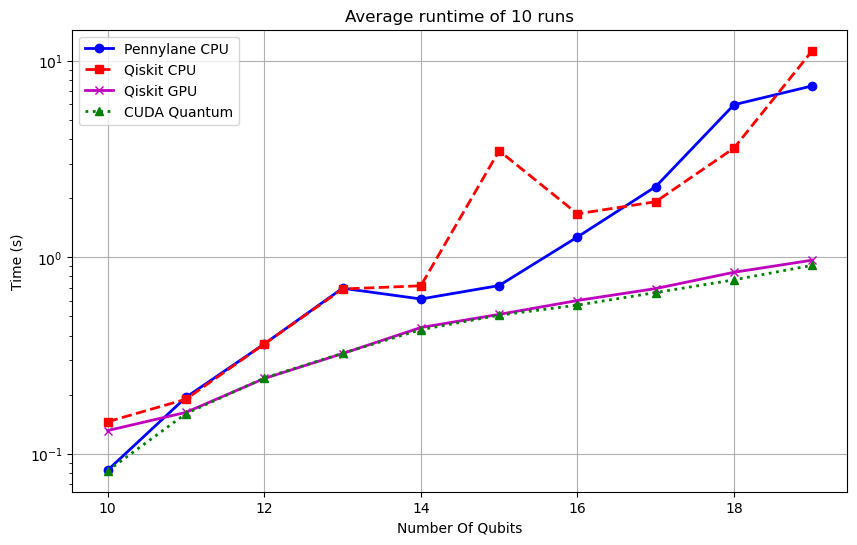

In [14]:
pennylane_default = [0.08265026244334876,
 0.19401208260096608,
 0.36253016320988535,
 0.696146191842854,
 0.6139039143919944,
 0.7183359822258353,
 1.2686408817768098,
 2.2884894280228765,
 5.974299326818437,
 7.450464610569179] 

qiskit_default = [0.14577143606729806,
 0.18977510100230574,
 0.3622487920336425,
 0.6900202533695847,
 0.7164735754020513,
 3.4860484146513047,
 1.6646287783514708,
 1.9181360151618718,
 3.5936100111342966,
 11.24890049980022] 

qiskit_GPU = [0.13144086878746747,
 0.16265760799869894,
 0.24184973016381264,
 0.32376781199127436,
 0.4394731789827347,
 0.5124840108212083,
 0.6029365699738264,
 0.6935588592197746,
 0.8393034366890788,
 0.967369829211384] 

CUDA_SDK = [0.0821025756187737,
 0.16024912539869546,
 0.24325067964382469,
 0.32509657577611506,
 0.42840386857278645,
 0.5077826207969338,
 0.5713453786447644,
 0.6616535493638367,
 0.76805939078331,
 0.9106043060310185] 
import matplotlib.pyplot as plt

x = list(range(10,20))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first line
plt.plot(x, pennylane_default, label='Pennylane CPU', color='b', marker='o', linestyle='-', linewidth=2)

# Plot the second line
plt.plot(x, qiskit_default, label='Qiskit CPU', color='r', marker='s', linestyle='--', linewidth=2)
plt.plot(x, qiskit_GPU, label='Qiskit GPU', color='m', marker='x', linestyle='-', linewidth=2)
plt.plot(x, CUDA_SDK, label='CUDA Quantum', color='g', marker='^', linestyle=':', linewidth=2)

plt.yscale('log')
# Customize the plot
plt.title('Average runtime of 10 runs')
plt.xlabel('Number Of Qubits')
plt.ylabel('Time (s)')
plt.grid(True)
plt.legend()

# Parallel Exact Quantum Embedding
A series of python modules for implementing quantum amplitude embedding, which fulfills the challenge "Preparing for Battle".

The report goes through several embedding schemes we have come up with that are either good for simulating (simulator friendly encodings). 
The main feature is that we have implemented an embedding in qiskit for the FRQI-QPIXL framework  (Amankwah et al., May 2022, https://www.nature.com/articles/s41598-022-11024-y ) and have found a way to parallelize data input so that you can now embed $N$ $2^N$ arrays in $2N$ qubits with the same circuit depth.
This is included in three folders, one for a qiskit version, a pennylane version and a CuQuantum version.  ```qpixl.py``` contains the original QPIXL algorithm, and  ```param_qpixl.py``` contains its parameterized version that can be used to generate a NISQ friendly image feature map for QML amongst other things. The fies with ```parallel``` include the parallelized versions of the very saame codes. 

- Contents
    - Introduction
    - QPIXL revisited
    - compression
    - parallel QPIXL
    - QML with full quantum embedding

# QPIXL


## Introduction

### Quantum killers for NISQ
The depth (and connectivity) of a circuit completely determines how well it can be implemented on existing hardware. The killing blow to most
algorithms is that they require fully connected and very deep circuits (which get decomposed to even deeper circuits with limited gatesets). 
Due to non-zero error rates, the probability that at least an error has occured throughout the run of a circuit eventually becomes 1. This can
be mitigated, but at some point it can't be done. This is why short circuits for flexible data embeddings are so important. Assuming appropiate connectivity, it is possible to multiply the amount of data encoded within a constant depth.

### Images in quantum computing
Although quantum computers have a more obvious to see advantage in quantum tasks, nonetheless it is thought that we can see some advantages in tasks involving
classical data loaded onto a quantum computer. Although pictures may not be 'the' data-type that will see an advantage from quantum computing, it is nonetheless 
the case that a lot of data can be input in an image-like format, and studying pictoral algorihtms is definitely way easier on the eyes than pure data-driven tasks! 
Also, with a quantum state representing an image, you can see the results of any quantum transformation of the picture as a new picture! Of course, it needs to be 
seen from many 'angles', but maybe it can help with visualizing what is happening. Of course, images are just a stand in for arbitrary real valued data.

## QPIXL algorithm

Why do we need another type of embedding in the mix? QPIXL is a framework to decompose popular image encodings such as FRQI, NEQR and their improved counterparts. 
It works by optimally decomposing the gates, and removing any 0 angles that are found. Thanks to the optimal decomposition
the quantum gates can then be further reduced by removing pairs of CNOTS that used to be interweaved by rotation gates. 
They cancel out an become the identity. 
The FRQI embedding looks as follows: 

In [3]:
from QPIXL_qiskit.helper import *
from QPIXL_qiskit.qpixl_parallel import *
from qiskit.visualization import *
from qiskit_aer import StatevectorSimulator
import qiskit 
from PIL import Image
import matplotlib.pyplot as plt
#from qiskit.providers.aer import *
backend = StatevectorSimulator()
#backend = AerSimulator(method='statevector', device='GPU', cuStateVec_enable=True)

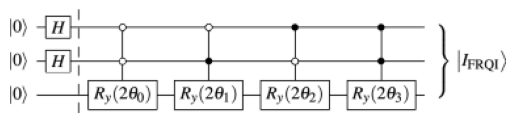

In [4]:
frqi_img = Image.open('figures/frqi.png')
plt.imshow(frqi_img)
plt.axis('off')
plt.show()

but decomposed into CNOTS and rotations it looks like this!

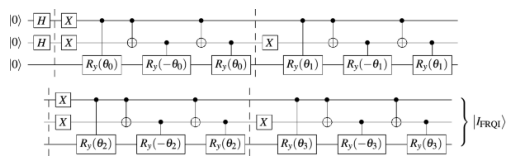

In [5]:
frqi_decomp_img = Image.open('figures/frqi_decomp.png')
plt.imshow(frqi_decomp_img)
plt.axis('off')
plt.show()

With QPIXL, the basic embedding, after transforming the image into an angle representation (using arctangent on the pixel values and a walsh hadamard transform) you have this much shorter decomposition! 
And this implies that we encode each of its elements into the amplitudes of the wave function.

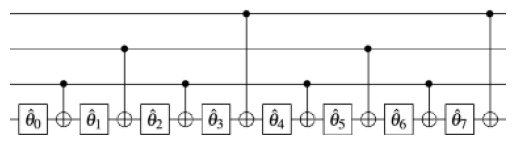

In [6]:
plt.close()
qpixl_decomp_img = Image.open('figures/qpixl_decomp.png')
plt.imshow(qpixl_decomp_img)
plt.axis('off')
plt.show()

## Implement multiple datasets in the same address qubits

The structure of QPIXL lends itself to a curious extension. Since the address qubits (all but the bottom qubit above) are each addressed by the data qubit (the lowest one in the figures above) individually. It is actually possible to add an additional data qubit (the one with the rotations) that then addresses a cyclic permutation of the qubits. This is shown below for some random data.  This parallelization method was inspired by the paper (Balewski, J., Amankwah, M.G., Van Beeumen, R. et al., Sci Rep 14, 3435 (2024), https://doi.org/10.1038/s41598-024-53720-x). 

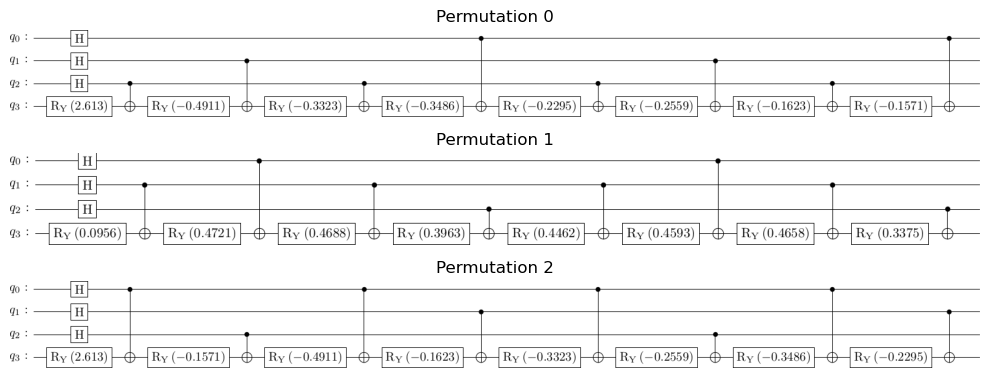

In [7]:
np_frame = [np.random.random(8)] #just some random arrays
decoded_data = []
labels = []
comp_str = "Compression: "+str(0)+"% \n"
fig, ax = plt.subplots(3, 1, figsize=(10, 4))
for i in range(3):
    qc = cFRQI(np_frame,0,i).reverse_bits()
    ax[i].imshow(qc.draw('latex'))
    ax[i].axis('off')
    ax[i].set_title(f'Permutation {i}')
plt.tight_layout()
plt.show()

## Combining the three data streams into one!
As you can see, and hopefully believe, the three different permutation never intersect at any slice of the circuit, and as such, you can combine all three data streams into a single one! This can be easily done in this code by giving an array with up to N elements, where N is the number of address qubits. Now, in the same depth you can encode N arrays, and the bigger the single array, the bigger the savings in depth, since the QPIXL algorithm is linear in depth with respect to the number of elements in the array (0 entries are actually 'compressed' out, so padding is always a valid strategy)

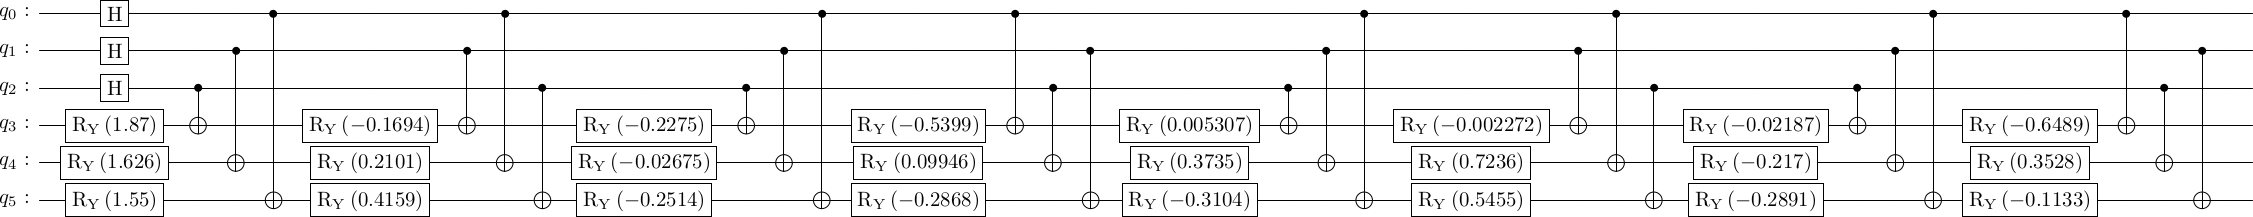

In [6]:
np_frame = [np.random.random(8) for i in range(ilog2(8))] #just some random arrays
decoded_data = []
labels = []
comp_str = "Compression: "+str(0)+"% \n"
qc = cFRQI(np_frame,0).reverse_bits()
qc.draw('latex')

# Encoding and decoding
Below, we show how you encode and then decode multiple images within one circuit. First you load and inspect your beautiful dataset

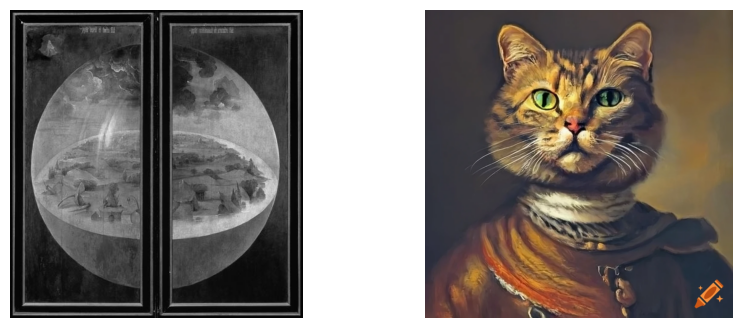

In [7]:
img = Image.open('figures/creation_world.png')
img2 = Image.open('figures/cat.webp')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.axis('off')
ax2.axis('off')
ax1.imshow(img)
ax2.imshow(img2)
plt.show()

Now we can either pad or resize the data. Since these are images, we will make black and white copies with a size of 2^N pixels, which in this case is going to be 12 qubits, or 64*64 pixels. 

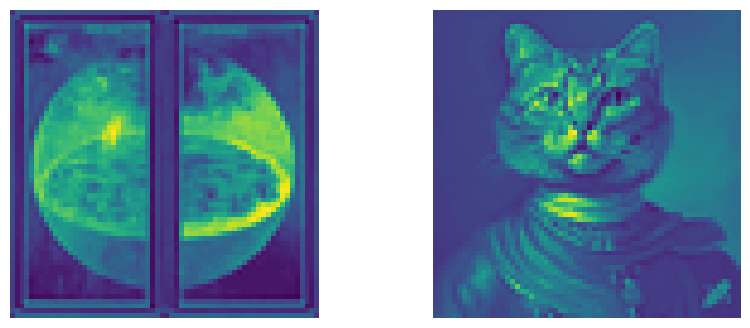

In [8]:
img = img.convert('L')
img = np.array(img.resize((64,64), Image.Resampling.LANCZOS))
img2 = img2.convert('L')
img2 = np.array(img2.resize((64,64), Image.Resampling.LANCZOS))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.axis('off')
ax2.axis('off')
ax1.imshow(img)
ax2.imshow(img2)
plt.show()

Not quite as majestic as the originals, but they are quantum ready, so to the trained eye, the compressed versions are even more special. 
In the circuit, we need 12+2 qubits, 12 qubits address the 64*64 pixels, and the other two qubits encode the angles that represent the data. We encode the data as before

In [9]:
shape = img.shape
np_frame = [np.array(img).T.flatten(),np.array(img2).T.flatten()] #sometimes you have to transpose the image for the decoding to make sense
decoded_data = []
qc = cFRQI(np_frame,0)
job = backend.run(qc)
sv = np.real(job.result().get_statevector())

Unlike in qpixl that had a fairly straightforward encoding scheme, here we must trace out all data qubits except for the one that we want, and then permute the binary addresses back to what they would be before the cyclic permutation. For the implementation, you may inspect the code below, but suffice it to say that if you have $D$ data qubits and you are interested in image $d$ you would just take the partial trace
$$\rho_\text{d}=\text{Tr}_{D\neq d}[\rho_\text{full}]$$

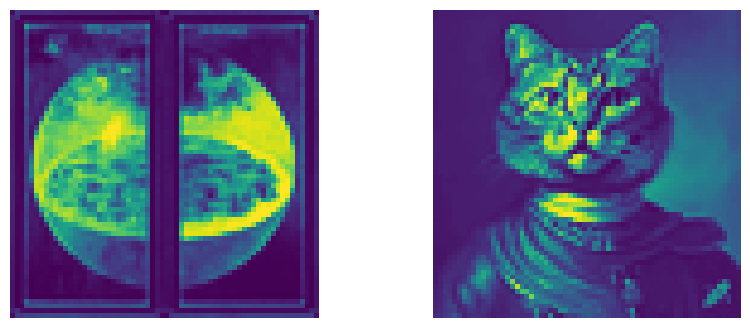

In [11]:
decoded = decodeParallelQPIXL(sv,qc,len(np_frame))
for datum in decoded:
    decoded_data.append(reconstruct_img(datum, shape))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.axis('off')
ax2.axis('off')
ax1.imshow(decoded_data[0])
ax2.imshow(decoded_data[1])
plt.show()

As you can see, the data has been successfuly recovered - the decoded data should in theory be exactly the same as the data put in, but the output images use 8bit color, so there is some rounding that would not exist with a slightly different implementation. The encoded state itself perfectly encodes the input data. 

# QML with fully quantum embedded data
With parallel QPIXL it is in theory possible to do bathced data upload for QML. For this task we have used the MNIST dataset, and attempted to encode the whole image onto the quantum computer via the circuit. The idea was to upload 10 '1' images at once (since the closest power of two to the image size is $2^{10}$) and likewise for the 0's during training. Sadly, 20 qubits for just the data circuit + the QML part turned out to be too much, so we were unable to use this idea. The code is there in ```QPIXL_QML```, but although it does run, more work is needed on the actual QML structure and important expectation values. It would be interesting to see how this compares to standard QPIXL and other embedding schemes. 